In [ ]:

# IMPORTANT: RUN THIS CELL IN ORDER TO IMPORT YOUR KAGGLE DATA SOURCES
# TO THE CORRECT LOCATION (/kaggle/input) IN YOUR NOTEBOOK,
# THEN FEEL FREE TO DELETE THIS CELL.
# NOTE: THIS NOTEBOOK ENVIRONMENT DIFFERS FROM KAGGLE'S PYTHON
# ENVIRONMENT SO THERE MAY BE MISSING LIBRARIES USED BY YOUR
# NOTEBOOK.

import os
import sys
from tempfile import NamedTemporaryFile
from urllib.request import urlopen
from urllib.parse import unquote, urlparse
from urllib.error import HTTPError
from zipfile import ZipFile
import tarfile
import shutil

CHUNK_SIZE = 40960
DATA_SOURCE_MAPPING = 'brain-mri-images-for-brain-tumor-detection:https%3A%2F%2Fstorage.googleapis.com%2Fkaggle-data-sets%2F165566%2F377107%2Fbundle%2Farchive.zip%3FX-Goog-Algorithm%3DGOOG4-RSA-SHA256%26X-Goog-Credential%3Dgcp-kaggle-com%2540kaggle-161607.iam.gserviceaccount.com%252F20240430%252Fauto%252Fstorage%252Fgoog4_request%26X-Goog-Date%3D20240430T063446Z%26X-Goog-Expires%3D259200%26X-Goog-SignedHeaders%3Dhost%26X-Goog-Signature%3D2e21b7f61a7cba13607e0aef7b6b9f031fd56a50699521701c8c40fca3bc00d77c68d2e28e0b2cf90531e4c7c703e48547a36db7be5181f2513de819b20547061d0d709addd462a44eacf973cb70c6fa84177c4498c1c3b72dd8374a357d491289b6695257d0e42a89235483bb4a362d7f5064848e975a0ec0770ff531313e094dcbfad9f655b61ab7586b355032fa1dd7602ffb6f10899313d48ed3a5488ba9e3666c4099102699aa84c27f990d1d77d01f716aa0ec950b0c9c5672dbaa130f19bead0fcc532da57cc6b59f92322a9961988609b6729b9ffaaf8df2773eafa8f97144732b145e49360d08fc57716da44dd89b9f315dd7f72a4a2b72eda93da6'

KAGGLE_INPUT_PATH='/kaggle/input'
KAGGLE_WORKING_PATH='/kaggle/working'
KAGGLE_SYMLINK='kaggle'

!umount /kaggle/input/ 2> /dev/null
shutil.rmtree('/kaggle/input', ignore_errors=True)
os.makedirs(KAGGLE_INPUT_PATH, 0o777, exist_ok=True)
os.makedirs(KAGGLE_WORKING_PATH, 0o777, exist_ok=True)

try:
  os.symlink(KAGGLE_INPUT_PATH, os.path.join("..", 'input'), target_is_directory=True)
except FileExistsError:
  pass
try:
  os.symlink(KAGGLE_WORKING_PATH, os.path.join("..", 'working'), target_is_directory=True)
except FileExistsError:
  pass

for data_source_mapping in DATA_SOURCE_MAPPING.split(','):
    directory, download_url_encoded = data_source_mapping.split(':')
    download_url = unquote(download_url_encoded)
    filename = urlparse(download_url).path
    destination_path = os.path.join(KAGGLE_INPUT_PATH, directory)
    try:
        with urlopen(download_url) as fileres, NamedTemporaryFile() as tfile:
            total_length = fileres.headers['content-length']
            print(f'Downloading {directory}, {total_length} bytes compressed')
            dl = 0
            data = fileres.read(CHUNK_SIZE)
            while len(data) > 0:
                dl += len(data)
                tfile.write(data)
                done = int(50 * dl / int(total_length))
                sys.stdout.write(f"\r[{'=' * done}{' ' * (50-done)}] {dl} bytes downloaded")
                sys.stdout.flush()
                data = fileres.read(CHUNK_SIZE)
            if filename.endswith('.zip'):
              with ZipFile(tfile) as zfile:
                zfile.extractall(destination_path)
            else:
              with tarfile.open(tfile.name) as tarfile:
                tarfile.extractall(destination_path)
            print(f'\nDownloaded and uncompressed: {directory}')
    except HTTPError as e:
        print(f'Failed to load (likely expired) {download_url} to path {destination_path}')
        continue
    except OSError as e:
        print(f'Failed to load {download_url} to path {destination_path}')
        continue

print('Data source import complete.')


[==================================================] 15828590 bytes downloaded
Downloaded and uncompressed: brain-mri-images-for-brain-tumor-detection
Data source import complete.


# Import Statements

In [ ]:
import os
import keras
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization
from PIL import Image
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
plt.style.use('dark_background')
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder

# One Hot Encoding the Target Classes

In [ ]:
encoder = OneHotEncoder()
encoder.fit([[0], [1]])

# 0 - Tumor
# 1 - Normal

OneHotEncoder()

# Creating 3 Important Lists --
1. data list for storing image data in numpy array form
2. paths list for storing paths of all images
3. result list for storing one hot encoded form of target class whether normal or tumor

In [ ]:
# This cell updates result list for images with tumor

data = []
paths = []
result = []

for r, d, f in os.walk(r'../input/brain-mri-images-for-brain-tumor-detection/yes'):
    for file in f:
        if '.jpg' in file:
            paths.append(os.path.join(r, file))

for path in paths:
    img = Image.open(path)
    img = img.resize((128,128))
    img = np.array(img)
    if(img.shape == (128,128,3)):
        data.append(np.array(img))
        result.append(encoder.transform([[0]]).toarray())

In [ ]:
# This cell updates result list for images without tumor

paths = []
for r, d, f in os.walk(r"../input/brain-mri-images-for-brain-tumor-detection/no"):
    for file in f:
        if '.jpg' in file:
            paths.append(os.path.join(r, file))

for path in paths:
    img = Image.open(path)
    img = img.resize((128,128))
    img = np.array(img)
    if(img.shape == (128,128,3)):
        data.append(np.array(img))
        result.append(encoder.transform([[1]]).toarray())

In [ ]:
data = np.array(data)
data.shape

(139, 128, 128, 3)

In [ ]:
result = np.array(result)
result = result.reshape(139,2)

# Splitting the Data into Training & Testing

In [ ]:
x_train,x_test,y_train,y_test = train_test_split(data, result, test_size=0.2, shuffle=True, random_state=0)

# Model Building

Batch normalization is a technique for training very deep neural networks that standardizes the inputs to a layer for each mini-batch. This has the effect of stabilizing the learning process and dramatically reducing the number of training epochs required to train deep networks.

In [ ]:
model = Sequential()

model.add(Conv2D(32, kernel_size=(2, 2), input_shape=(128, 128, 3), padding = 'Same'))
model.add(Conv2D(32, kernel_size=(2, 2),  activation ='relu', padding = 'Same'))


model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(64, kernel_size = (2,2), activation ='relu', padding = 'Same'))
model.add(Conv2D(64, kernel_size = (2,2), activation ='relu', padding = 'Same'))

model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2), strides=(2,2)))
model.add(Dropout(0.25))

model.add(Flatten())

model.add(Dense(512, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(2, activation='softmax'))

model.compile(loss = "categorical_crossentropy", optimizer='Adamax')
print(model.summary())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 128, 128, 32)      416       
                                                                 
 conv2d_1 (Conv2D)           (None, 128, 128, 32)      4128      
                                                                 
 batch_normalization (Batch  (None, 128, 128, 32)      128       
 Normalization)                                                  
                                                                 
 max_pooling2d (MaxPooling2  (None, 64, 64, 32)        0         
 D)                                                              
                                                                 
 dropout (Dropout)           (None, 64, 64, 32)        0         
                                                                 
 conv2d_2 (Conv2D)           (None, 64, 64, 64)        8

In [ ]:
y_train.shape

(111, 2)

In [ ]:
history = model.fit(x_train, y_train, epochs = 30, batch_size = 40, verbose = 1,validation_data = (x_test, y_test))

Epoch 1/30
3/3 [==============================] - 12s 3s/step - loss: 97.5667 - val_loss: 12.1929
Epoch 2/30
3/3 [==============================] - 8s 3s/step - loss: 17.2321 - val_loss: 46.5422
Epoch 3/30
3/3 [==============================] - 9s 3s/step - loss: 11.8069 - val_loss: 8.0971
Epoch 4/30
3/3 [==============================] - 9s 3s/step - loss: 7.6493 - val_loss: 18.3218
Epoch 5/30
3/3 [==============================] - 8s 3s/step - loss: 8.7852 - val_loss: 12.7837
Epoch 6/30
3/3 [==============================] - 10s 3s/step - loss: 3.4826 - val_loss: 4.9738
Epoch 7/30
3/3 [==============================] - 15s 5s/step - loss: 1.0365 - val_loss: 7.2549
Epoch 8/30
3/3 [==============================] - 9s 3s/step - loss: 1.3944 - val_loss: 9.6220
Epoch 9/30
3/3 [==============================] - 8s 3s/step - loss: 1.1938 - val_loss: 8.0677
Epoch 10/30
3/3 [==============================] - 9s 3s/step - loss: 0.9346 - val_loss: 5.3616
Epoch 11/30
3/3 [======================

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Plotting Losses

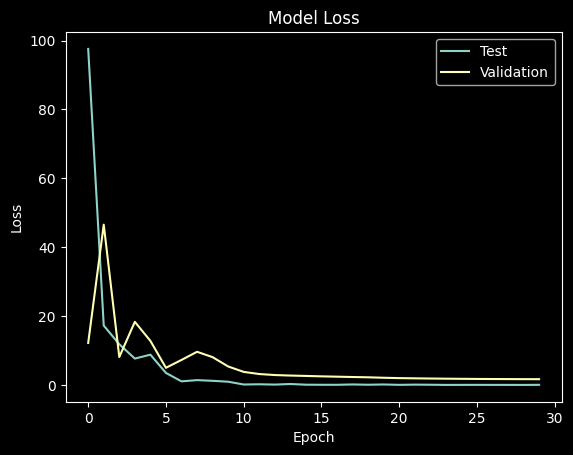

In [ ]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Test', 'Validation'], loc='upper right')
plt.show()

# Just Checking the Model

In [ ]:
def names(number):
    if number==0:
        return 'Its a Tumor'
    else:
        return 'No, Its not a tumor'

100.0% Confidence This Is No, Its not a tumor


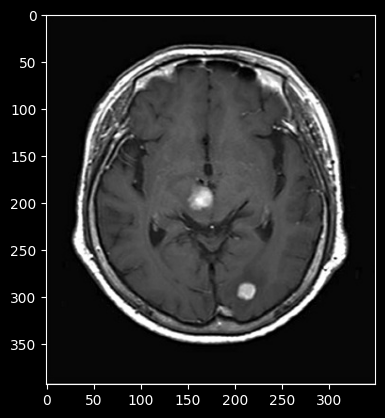

In [ ]:
from matplotlib.pyplot import imshow
img = Image.open(r"../input/brain-mri-images-for-brain-tumor-detection/no/N17.jpg")
x = np.array(img.resize((128,128)))
x = x.reshape(1,128,128,3)
res = model.predict_on_batch(x)
classification = np.where(res == np.amax(res))[1][0]
imshow(img)
print(str(res[0][classification]*100) + '% Confidence This Is ' + names(classification))

100.0% Confidence This Is A Its a Tumor


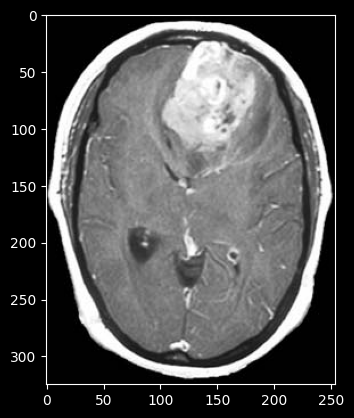

In [ ]:
from matplotlib.pyplot import imshow
img = Image.open(r"../input/brain-mri-images-for-brain-tumor-detection/yes/Y13.jpg")
x = np.array(img.resize((128,128)))
x = x.reshape(1,128,128,3)
res = model.predict_on_batch(x)
classification = np.where(res == np.amax(res))[1][0]
imshow(img)
print(str(res[0][classification]*100) + '% Confidence This Is A ' + names(classification))

# Thats It !!